# Ingesting Housing Market Data from SNB

Data is Housing Price Index from SNB. All values are relative to year 2000 prices (2000 = 100%)

In [29]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    # Get the JSON data
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Extract values | Each row are the values for a different property type and data provider
        values_df = pd.DataFrame(series['values'])
        
        # Add metadata columns
        values_df['property_type'] = property_type
        values_df['data_provider'] = data_provider
        
        # Dont need these columns
        #values_df['unit'] = series['metadata']['unit']
        #values_df['frequency'] = series['metadata']['frequency']
        
        # Append to our list
        all_series.append(values_df)
    
    # Combine all series into one DataFrame
    base_df = pd.concat(all_series, ignore_index=True)
    
    # Convert date column to datetime
    base_df['date'] = pd.to_datetime(base_df['date'], format='%Y')
    
    # Convert value column to numeric
    base_df['value'] = pd.to_numeric(base_df['value'])
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

,date,value,property_type,data_provider
0,2017-01-01,94.052037,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
1,2018-01-01,96.735820,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
2,2019-01-01,100.000000,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
3,2020-01-01,102.185954,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
4,2021-01-01,107.784384,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...


In [5]:
print("unique property types:")
for type in base_df['property_type'].unique():
    print(type)
print('='*100)

print("unique data providers:")
for provider in base_df['data_provider'].unique():
    print(provider)
print('='*100)

unique property types:
Residential property prices - Privately owned apartments
Residential property prices - Single-family houses
Residential property prices - Apartment buildings (residential investment property)
Rents - Rental housing units
Rents - Office space
Rents - Industrial and commercial space
Rents - Retail space
unique data providers:
Swiss Federal Statistical Office - Transaction price
Fahrländer Partner - Transaction price
IAZI - Transaction price
Wüest Partner - Asking price
Wüest Partner - Transaction price


All data is stacked one collumn for the value but there are:
- different property types (Residential property vs. Rents) and (Privately owned appartments vs. Single-family houses)
- different data providers (OFS vs Wuest vs IAZI) and price type (Asking price vs. Transaction price)

for the purpose of predicting the housing market, we want to have a dataframe that has:
- One column for the asking price and one for the transaction price
- One column residential property prices and one for rents by asking price or transaction price
- average together the data providers by price type and property type

Let's start by parsing the data into unique columns



In [30]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()
    
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Create a DataFrame from the values
        df = pd.DataFrame(series['values'])
        
        # Create a descriptive column name from property type and data provider
        column_name = f"{property_type} - {data_provider}"
        
        # Convert the values to numeric
        df['value'] = pd.to_numeric(df['value'])
        
        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'], format='%Y')
        
        # Add to list with series information
        all_series.append((df, column_name))
    
    # Start with the first series to get all dates
    base_df = all_series[0][0][['date']].copy()
    
    # Add each series as a new column
    for df, column_name in all_series:
        base_df = base_df.merge(
            df[['date', 'value']], 
            on='date', 
            how='outer'
        )
        base_df = base_df.rename(columns={'value': column_name})
    
    # Sort by date
    base_df = base_df.sort_values('date')
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

,date,Residential property prices - Privately owned apartments - Swiss Federal Statistical Office - Transaction price,Residential property prices - Privately owned apartments - Fahrländer Partner - Transaction price,Residential property prices - Privately owned apartments - IAZI - Transaction price,Residential property prices - Privately owned apartments - Wüest Partner - Asking price,Residential property prices - Privately owned apartments - Wüest Partner - Transaction price,Residential property prices - Single-family houses - Swiss Federal Statistical Office - Transaction price,Residential property prices - Single-family houses - Fahrländer Partner - Transaction price,Residential property prices - Single-family houses - IAZI - Transaction price,Residential property prices - Single-family houses - Wüest Partner - Asking price,Residential property prices - Single-family houses - Wüest Partner - Transaction price,Residential property prices - Apartment buildings (residential investment property) - Fahrländer Partner - Transaction price,Residential property prices - Apartment buildings (residential investment property) - IAZI - Transaction price,Residential property prices - Apartment buildings (residential investment property) - Wüest Partner - Transaction price,Rents - Rental housing units - Wüest Partner - Asking price,Rents - Office space - Wüest Partner - Asking price,Rents - Industrial and commercial space - Wüest Partner - Asking price,Rents - Retail space - Wüest Partner - Asking price
0,1970-01-01,NaN,NaN,NaN,37.067421,NaN,NaN,NaN,NaN,36.476339,NaN,NaN,NaN,NaN,34.664977,48.588164,46.120740,57.492516
1,1971-01-01,NaN,NaN,NaN,40.041925,NaN,NaN,NaN,NaN,41.771233,NaN,NaN,NaN,NaN,40.164850,52.454522,54.266010,54.101961
2,1972-01-01,NaN,NaN,NaN,45.192274,NaN,NaN,NaN,NaN,50.331605,NaN,NaN,NaN,NaN,45.606831,59.946112,56.381710,72.492423
3,1973-01-01,NaN,NaN,NaN,51.021098,NaN,NaN,NaN,NaN,59.446265,NaN,NaN,NaN,NaN,50.334182,64.896925,66.659691,76.553432
4,1974-01-01,NaN,NaN,NaN,50.419630,NaN,NaN,NaN,NaN,59.588616,NaN,NaN,NaN,NaN,53.390472,65.482283,63.007929,72.950228


## Defining some cleaning functions

In [ ]:
import re

def import_snb_housing_data(url="https://data.snb.ch/api/cube/plimoincha/data/json/en"):
    try:
        # Get the data from the SNB API
        response = requests.get(url)
        response.raise_for_status()
        
        data = response.json()
        
        # Create a list to store all data
        rows = []
        
        # Process each timeseries
        for series in data['timeseries']:
            # Extract header information
            property_type = series['header'][0]['dimItem']
            data_provider = series['header'][1]['dimItem']
            column_name = f"{property_type} - {data_provider}"
            
            # Add each value row with metadata
            for value in series['values']:
                rows.append({
                    'date': pd.to_datetime(value['date'], format='%Y'),
                    'value': pd.to_numeric(value['value']),
                    'column_name': column_name
                })
        
        # Create DataFrame from all rows
        df = pd.DataFrame(rows)
        
        # Pivot to get wide format
        base_df = df.pivot(index='date', columns='column_name', values='value')
        base_df = base_df.reset_index()
        
        return base_df.sort_values('date')
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

def remove_sfso_data(df):
    """
    Remove Swiss Federal Statistical Office data from the DataFrame
    """
    # Get columns that don't contain 'Swiss Federal Statistical Office'
    non_sfso_cols = [col for col in df.columns 
                     if 'Swiss Federal Statistical Office' not in col or col == 'date']
    
    return df[non_sfso_cols]

def split_residental_rents(df):
    # Get column masks
    residential_mask = df.columns.str.contains('Residential property prices') | (df.columns == 'date')
    rents_mask = df.columns.str.contains('Rents') | (df.columns == 'date')
    
    return df.loc[:, residential_mask], df.loc[:, rents_mask]

def average_providers(residential_df):
    types = {
        'Residential property prices': ['Privately owned apartments', 'Single-family houses', 'Apartment buildings (residential investment property)'],
        'price_type': ['Asking price', 'Transaction price'],
    }
    
    # Initialize the averaged DataFrame with the date column
    averaged_df = pd.DataFrame({'date': residential_df['date']})
    
    # For each combination of property type and price type
    for property_type in types['Residential property prices']:
        # For each price type (asking vs transaction)
        for price_type in types['price_type']:
            # Escape special regex characters in the pattern
            pattern = re.escape(property_type)
            price_pattern = 'Asking price' if 'Asking' in price_type else 'Transaction price'
            
            # Get columns that match the property type and price type simultaneously
            matching_cols = residential_df.columns[
                residential_df.columns.str.contains(pattern, regex=True, flags=re.IGNORECASE) & 
                residential_df.columns.str.contains(price_pattern, regex=False)
            ]
            
            if len(matching_cols) > 0:
                averaged_df[f"{property_type} - {price_type}"] = residential_df[matching_cols].mean(axis=1)
    
    return averaged_df

def stack_columns(df):
    # Melt the dataframe to get long format
    id_vars = ['date']
    value_vars = [col for col in df.columns if col != 'date']
    
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, 
                        var_name='property_price_type', value_name='value')
    
    # Split the property_price_type column
    melted_df[['property_type', 'price_type']] = melted_df['property_price_type'].str.split(' - ', n=1, expand=True)
    
    # Pivot to get asking and transaction prices as separate columns
    result_df = melted_df.pivot_table(
        index=['date', 'property_type'],
        columns='price_type',
        values='value'
    ).reset_index()
    
    # Rename columns
    result_df.columns.name = None
    result_df = result_df.rename(columns={
        'Asking price': 'asking_price',
        'Transaction price': 'transaction_price'
    })
    
    # Clean property type names
    result_df['property_type'] = result_df['property_type'].replace({
        'Apartment buildings (residential investment property)': 'Apartment buildings'
    })
    
    return result_df.sort_values(['date', 'property_type'])

def join_rents(combined_df, rents_df):
    # Rename rent columns more efficiently
    rent_cols = {col: '-'.join(col.split('-')[:2]) 
                 for col in rents_df.columns 
                 if col != 'date'}
    
    renamed_rents = rents_df.rename(columns=rent_cols)
    
    return pd.merge(combined_df, renamed_rents, on='date', how='outer')

def get_clean_housing_data(url="https://data.snb.ch/api/cube/plimoincha/data/json/en"):
    base_df = import_snb_housing_data(url)
    cleaned_df = remove_sfso_data(base_df)
    residential_df, rents_df = split_residental_rents(cleaned_df)
    averaged_df = average_providers(residential_df)
    combined_df = stack_columns(averaged_df)
    housing_df = join_rents(combined_df, rents_df)
    
    return {
        'base_df': base_df,
        'cleaned_df': cleaned_df,
        'residential_df': residential_df,
        'rents_df': rents_df,
        'averaged_df': averaged_df,
        'combined_df': combined_df,
        'housing_df': housing_df
    }

,date,property_type,asking_price,transaction_price,Rents - Industrial and commercial space,Rents - Office space,Rents - Rental housing units,Rents - Retail space
0,1970-01-01,Privately owned apartments,37.067421,NaN,46.120740,48.588164,34.664977,57.492516
1,1970-01-01,Single-family houses,36.476339,NaN,46.120740,48.588164,34.664977,57.492516
2,1971-01-01,Privately owned apartments,40.041925,NaN,54.266010,52.454522,40.164850,54.101961
3,1971-01-01,Single-family houses,41.771233,NaN,54.266010,52.454522,40.164850,54.101961
4,1972-01-01,Privately owned apartments,45.192274,NaN,56.381710,59.946112,45.606831,72.492423
...,...,...,...,...,...,...,...,...
134,2023-01-01,Privately owned apartments,187.658501,240.258694,117.251560,118.597196,142.719131,111.548723
135,2023-01-01,Single-family houses,189.898192,213.819478,117.251560,118.597196,142.719131,111.548723
136,2024-01-01,Apartment buildings,NaN,163.797819,119.401059,117.903731,149.401432,111.641745
137,2024-01-01,Privately owned apartments,188.501891,247.621496,119.401059,117.903731,149.401432,111.641745


In [28]:
dfs = get_clean_housing_data()
housing_df = dfs['housing_df']
housing_df

,date,property_type,asking_price,transaction_price,Rents - Industrial and commercial space,Rents - Office space,Rents - Rental housing units,Rents - Retail space
0,1970-01-01,Privately owned apartments,37.067421,NaN,46.120740,48.588164,34.664977,57.492516
1,1970-01-01,Single-family houses,36.476339,NaN,46.120740,48.588164,34.664977,57.492516
2,1971-01-01,Privately owned apartments,40.041925,NaN,54.266010,52.454522,40.164850,54.101961
3,1971-01-01,Single-family houses,41.771233,NaN,54.266010,52.454522,40.164850,54.101961
4,1972-01-01,Privately owned apartments,45.192274,NaN,56.381710,59.946112,45.606831,72.492423
...,...,...,...,...,...,...,...,...
134,2023-01-01,Privately owned apartments,187.658501,240.258694,117.251560,118.597196,142.719131,111.548723
135,2023-01-01,Single-family houses,189.898192,213.819478,117.251560,118.597196,142.719131,111.548723
136,2024-01-01,Apartment buildings,NaN,163.797819,119.401059,117.903731,149.401432,111.641745
137,2024-01-01,Privately owned apartments,188.501891,247.621496,119.401059,117.903731,149.401432,111.641745


## Plotting the Data and Descriptive Statistics

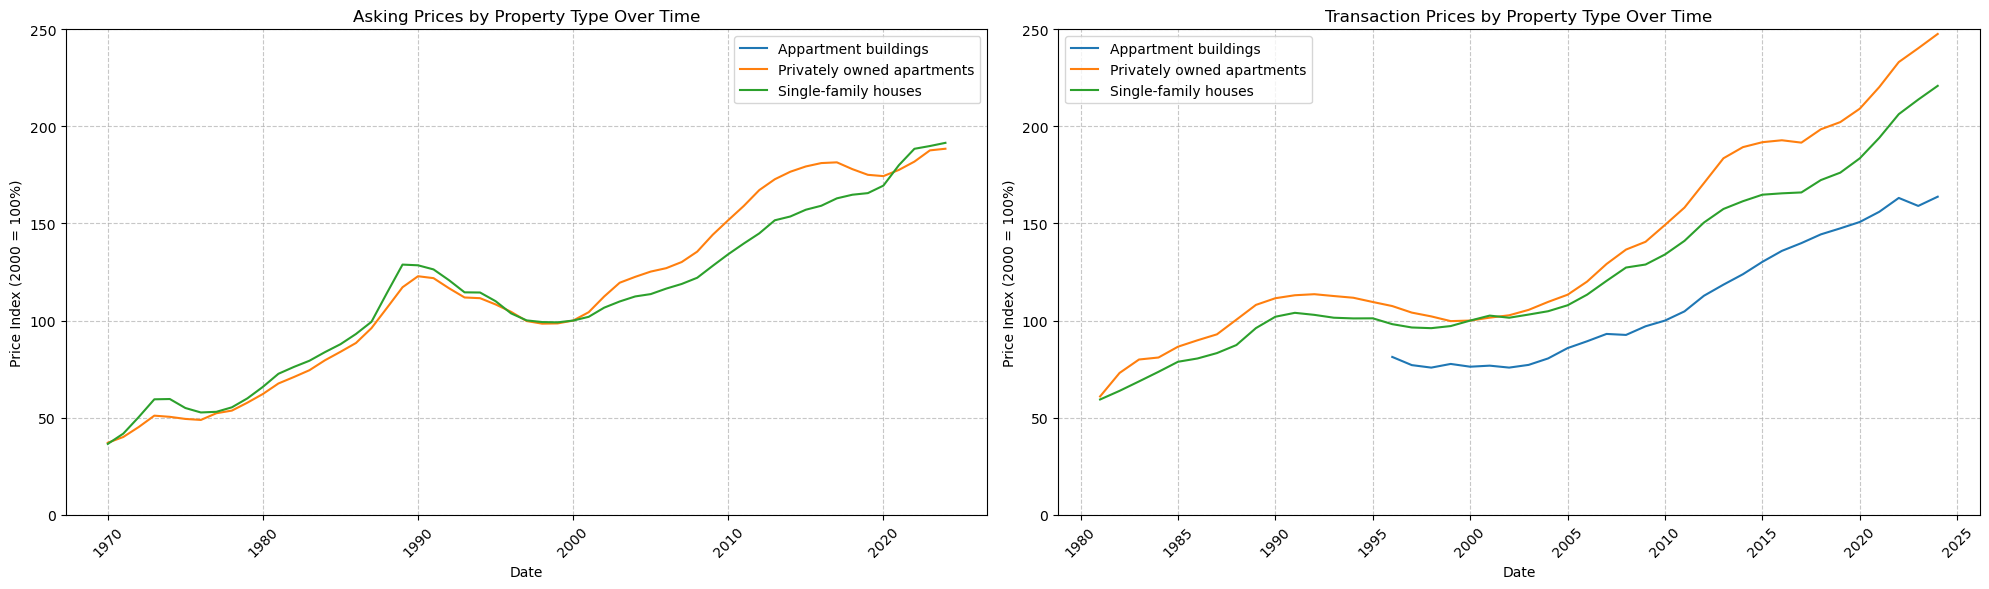

In [58]:
import matplotlib.pyplot as plt

# 1. Convert the 'date' column to datetime
housing_df['date'] = pd.to_datetime(housing_df['date'])

# 2. Define the three property types (make sure these match exactly!)
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create figure and axes for two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot - Asking Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax1.plot(data['date'], data['asking_price'], label=property_type)

# Customize first subplot
ax1.set_title('Asking Prices by Property Type Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price Index (2000 = 100%)')
ax1.set_ylim(0,250)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Second subplot - Transaction Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax2.plot(data['date'], data['transaction_price'], label=property_type)

# Customize second subplot
ax2.set_title('Transaction Prices by Property Type Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Index (2000 = 100%)')
ax2.set_ylim(0,250)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

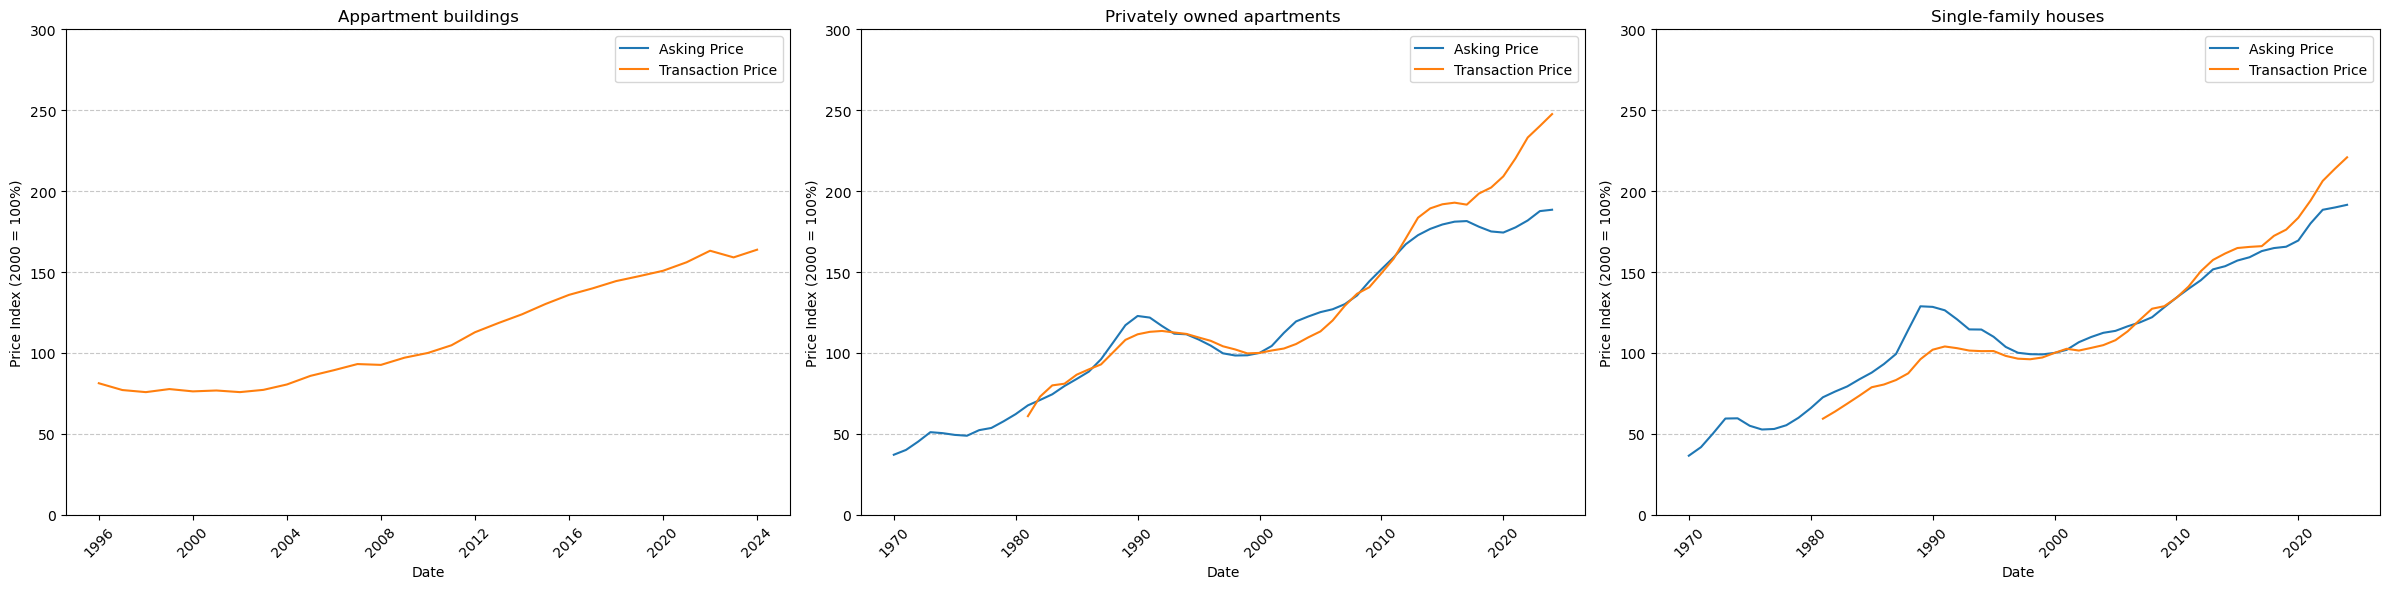

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axes for three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Define the property types
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create a dictionary mapping axes to property types for cleaner code
ax_property_pairs = [
    (ax1, property_types[0]),
    (ax2, property_types[1]),
    (ax3, property_types[2])
]

# Plot each property type in its own subplot
for ax, property_type in ax_property_pairs:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    
    # Plot both asking and transaction prices
    ax.plot(data['date'], data['asking_price'], label='Asking Price')
    ax.plot(data['date'], data['transaction_price'], label='Transaction Price')
    
    # Customize subplot
    ax.set_title(f'{property_type}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price Index (2000 = 100%)')
    ax.set_ylim([0, 300])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

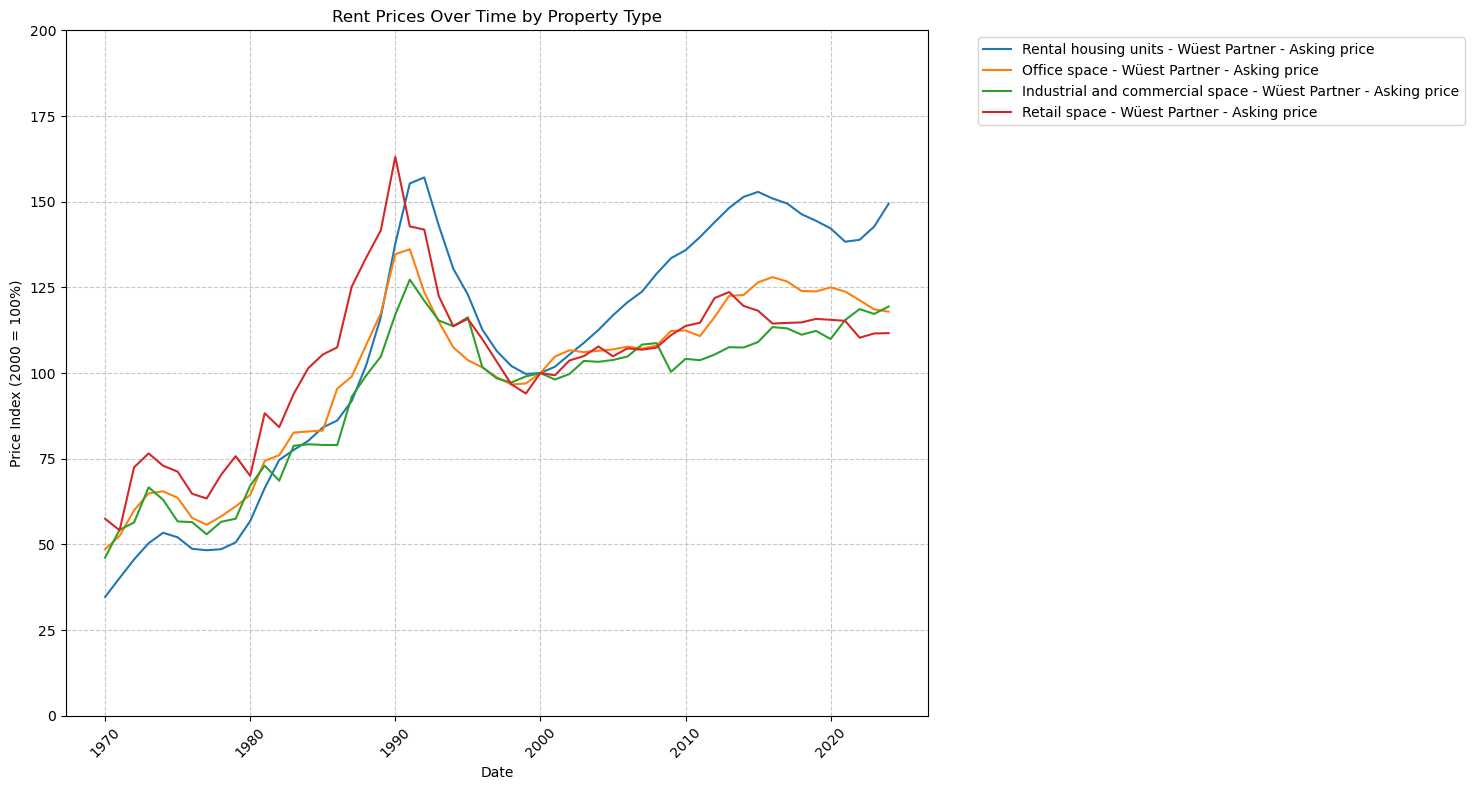

In [84]:
import matplotlib.pyplot as plt

rents_df = dfs['rents_df']

# Create figure and axis
plt.figure(figsize=(15, 8))

# Plot each rent type
rent_columns = []

for col in rents_df.columns:
    if col == 'date':
        continue
    rent_columns.append(col)

for column in rent_columns:
    plt.plot(rents_df['date'], rents_df[column], label=column.replace('Rents - ', ''))

# Customize plot
plt.title('Rent Prices Over Time by Property Type')
plt.xlabel('Date')
plt.ylabel('Price Index (2000 = 100%)')
plt.ylim([0, 200])
plt.yticks(range(0, 201, 25))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='x', rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
averaged_df = dfs['averaged_df']
rents_df = dfs['rents_df']

statistics_df = pd.concat([averaged_df, rents_df])

statistics_df.describe()

,date,Privately owned apartments - Asking price,Privately owned apartments - Transaction price,Single-family houses - Asking price,Single-family houses - Transaction price,Apartment buildings (residential investment property) - Transaction price,Rents - Rental housing units - Wüest Partner - Asking price,Rents - Office space - Wüest Partner - Asking price,Rents - Industrial and commercial space - Wüest Partner - Asking price,Rents - Retail space - Wüest Partner - Asking price
count,110,55.000000,44.000000,55.000000,44.000000,29.000000,55.000000,55.000000,55.000000,55.000000
mean,1996-12-31 14:50:10.909090944,114.179179,136.271265,111.350553,122.951590,110.578202,107.325324,99.493931,94.437113,104.042377
min,1970-01-01 00:00:00,37.067421,60.920272,36.476339,59.350776,75.768477,34.664977,48.588164,46.120740,54.101961
25%,1983-04-02 06:00:00,76.986206,101.989638,81.523272,96.984675,80.498467,78.881088,82.780355,78.886086,93.966269
50%,1997-01-01 00:00:00,111.889770,112.836369,112.424393,103.539813,100.000000,112.672272,106.645840,103.265784,107.498908
75%,2010-10-01 18:00:00,155.373856,185.025848,136.926460,158.481267,139.899647,140.950721,118.250464,110.555780,115.378562
max,2024-01-01 00:00:00,188.501891,247.621496,191.537261,220.900243,163.797819,157.069721,136.112678,127.254825,163.074886
std,NaN,46.340399,50.118778,40.936351,42.094341,31.690167,37.511768,24.390612,22.198375,22.685333


In [27]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, figsize=(11,9), vmin=-1, vmax=1, center=0, fmt='.2f'):
    """
    Creates and displays a correlation heatmap for the given dataframe
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to calculate correlations for
    figsize : tuple, optional
        Figure size as (width, height), default (11,9)
    vmin : float, optional
        Minimum value for the colormap, default 0
    vmax : float, optional 
        Maximum value for the colormap, default 1
    center : float, optional
        Center value for the colormap, default 0
    fmt : str, optional
        Format string for annotation values, default '.2f'
    """
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(240,10, sep=20, as_cmap=True)

    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                center=center, 
                square=True,
                linewidths=.5,
                cbar_kws={'shrink':.5},
                annot=True,
                fmt=fmt)
    
    plt.show()

# Use the function with the statistics dataframe
plot_correlation_heatmap(statistics_df, vmin=0)


NameError: name 'statistics_df' is not defined

# Importing Second Dataset:
Live births  
Deaths  
Natural Change  
Immigration  
Emigration  
Net migration  
Acquisition of Swiss citizenship

In [5]:
import requests
import pandas as pd
from io import StringIO

def get_demographics_data(url="https://dam-api.bfs.admin.ch/hub/api/dam/assets/32229365/master"):
    try:
        # Get the data from the API
        response = requests.get(url)
        response.raise_for_status() 
        
        # Convert the response content to a string buffer
        content = StringIO(response.text)
        
        # Read the CSV from the string buffer
        raw_demographics_df = pd.read_csv(content)

    except requests.exceptions.RequestException as e:
        print(f'Request error: {e}')
    except pd.errors.EmptyDataError as e:
        print(f'CSV parsing error: {e}')
    except Exception as e:
        print(f'An error occurred: {e}')
    
    return raw_demographics_df

def long_to_wide_demographics(raw_demographics_df):
    colname = raw_demographics_df.columns[0]
    raw_demographics_df=raw_demographics_df.rename(columns={colname: 'date'})
    
    component_key = {
        'LIVB': 'Live births',
        'DTH': 'Deaths',
        'NC': 'Natural Change',
        'IMMI': 'Immigration',
        'EMI': 'Emigration',
        'NMIG': 'Net migration',
        'ACQCH': 'Acquisition of Swiss citizenship',
        'STATADJ': 'Statistical adjustments'
    }
    
    raw_demographics_df['POPULATION_CHANGE_COMPONENT'] = raw_demographics_df['POPULATION_CHANGE_COMPONENT'].map(component_key)
    
    # Using pivot_table to handle duplicate values (if any)
    demographics_df = raw_demographics_df.pivot_table(
        index='date',
        columns='POPULATION_CHANGE_COMPONENT',
        values='VALUE',
        aggfunc='first'  # or 'mean', 'sum', etc. depending on what you want to do with duplicates
    ).reset_index()
    
    return demographics_df

In [6]:
raw_demographics_df = get_demographics_data()
raw_demographics_df

,"ï»¿""YEAR""",POPULATION_CHANGE_COMPONENT,VALUE,OBS_STATUS
0,1861,LIVB,74820.0,A
1,1862,LIVB,75870.0,A
2,1863,LIVB,79160.0,A
3,1864,LIVB,79600.0,A
4,1865,LIVB,78290.0,A
...,...,...,...,...
1299,2019,STATADJ,-238.0,A
1300,2020,STATADJ,744.0,A
1301,2021,STATADJ,1168.0,A
1302,2022,STATADJ,-112.0,A


In [8]:
demographics_df = long_to_wide_demographics(raw_demographics_df)
demographics_df

POPULATION_CHANGE_COMPONENT,date,Acquisition of Swiss citizenship,Deaths,Emigration,Immigration,Live births,Natural Change,Net migration,Statistical adjustments
0,1861,NaN,57520.0,NaN,NaN,74820.0,17300.0,381.0,NaN
1,1862,NaN,51070.0,NaN,NaN,75870.0,24800.0,-3620.0,NaN
2,1863,NaN,54360.0,NaN,NaN,79160.0,24800.0,-3408.0,NaN
3,1864,NaN,59500.0,NaN,NaN,79600.0,20100.0,-1194.0,NaN
4,1865,NaN,59090.0,NaN,NaN,78290.0,19200.0,-2653.0,NaN
...,...,...,...,...,...,...,...,...,...
158,2019,41127.0,67780.0,126221.0,169573.0,86172.0,18392.0,43352.0,-238.0
159,2020,34141.0,76195.0,109376.0,163180.0,85914.0,9719.0,53804.0,744.0
160,2021,36994.0,71192.0,116769.0,165640.0,89644.0,18452.0,48871.0,1168.0
161,2022,41486.0,74425.0,122123.0,190883.0,82371.0,7946.0,68760.0,-112.0


In [25]:
def plot_all_columns(df):
    """
    plots all numeric columns of a data frame with 'date' on the x-axis 
    """
    import matplotlib.pyplot as plt
    
    # Get numeric columns excluding the date column
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Create a figure with subplots arranged in a reasonable layout
    n_cols = 2  # Display 2 columns of plots
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate needed rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot each demographic metric
    for idx, column in enumerate(numeric_columns):
        axes[idx].plot(df['date'], df[column])
        axes[idx].set_title(column)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True)

    # Remove any empty subplots
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_all_columns(demographics_df)

NameError: name 'demographics_df' is not defined

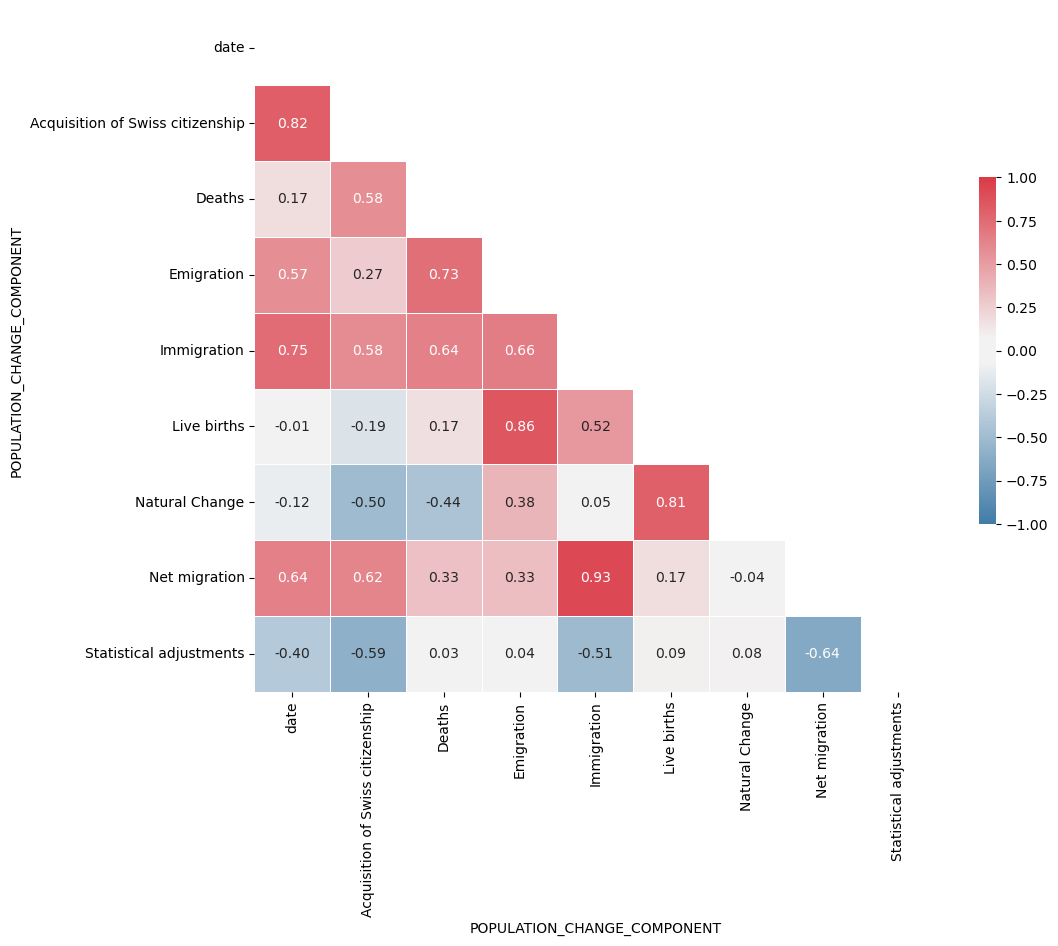

In [18]:
plot_correlation_heatmap(demographics_df, vmin=-1)

# Importing Monetary Data

## Interest rates

In [ ]:
from snb_data_processing import get_and_process_snb_data

interest_rates_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/zimoma/data/json/en")
interest_rates_df

,date,Switzerland - CHF - SARON - 1 day,Switzerland - CHF - Call money rate (Tomorrow next) - 1 day,Switzerland - CHF - Money market debt register claims of the Swiss Confederation - 3-month,Switzerland - CHF - CHF LIBOR - 3-month,United States - USD - SOFR - 1-day,United States - USD - USD LIBOR - 3-month,Japan - JPY - TONA - 1-day,Japan - JPY - JPY LIBOR - 3-month,United Kingdom - GBP - SONIA - 1-day,United Kingdom - GBP - GBP LIBOR - 3-month,Euro area - EUR - ESTR - 1-day,Euro area - EUR - EURIBOR - 3-month,Euro area - EUR - EUR LIBOR - 3-month
0,1972-01-01,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972-02-01,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972-03-01,NaN,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972-04-01,NaN,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972-05-01,NaN,1.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2024-09-01,0.957401,0.640,0.840,NaN,4.96,4.85372,0.225,NaN,4.9500,NaN,3.410,3.279,NaN
633,2024-10-01,0.949059,0.850,0.678,NaN,4.90,NaN,0.227,NaN,4.9500,NaN,3.155,3.062,NaN
634,2024-11-01,0.942743,0.730,0.559,NaN,4.59,NaN,0.227,NaN,4.7000,NaN,3.163,2.934,NaN
635,2024-12-01,0.451195,0.160,0.352,NaN,4.49,NaN,0.227,NaN,4.7003,NaN,2.905,2.714,NaN


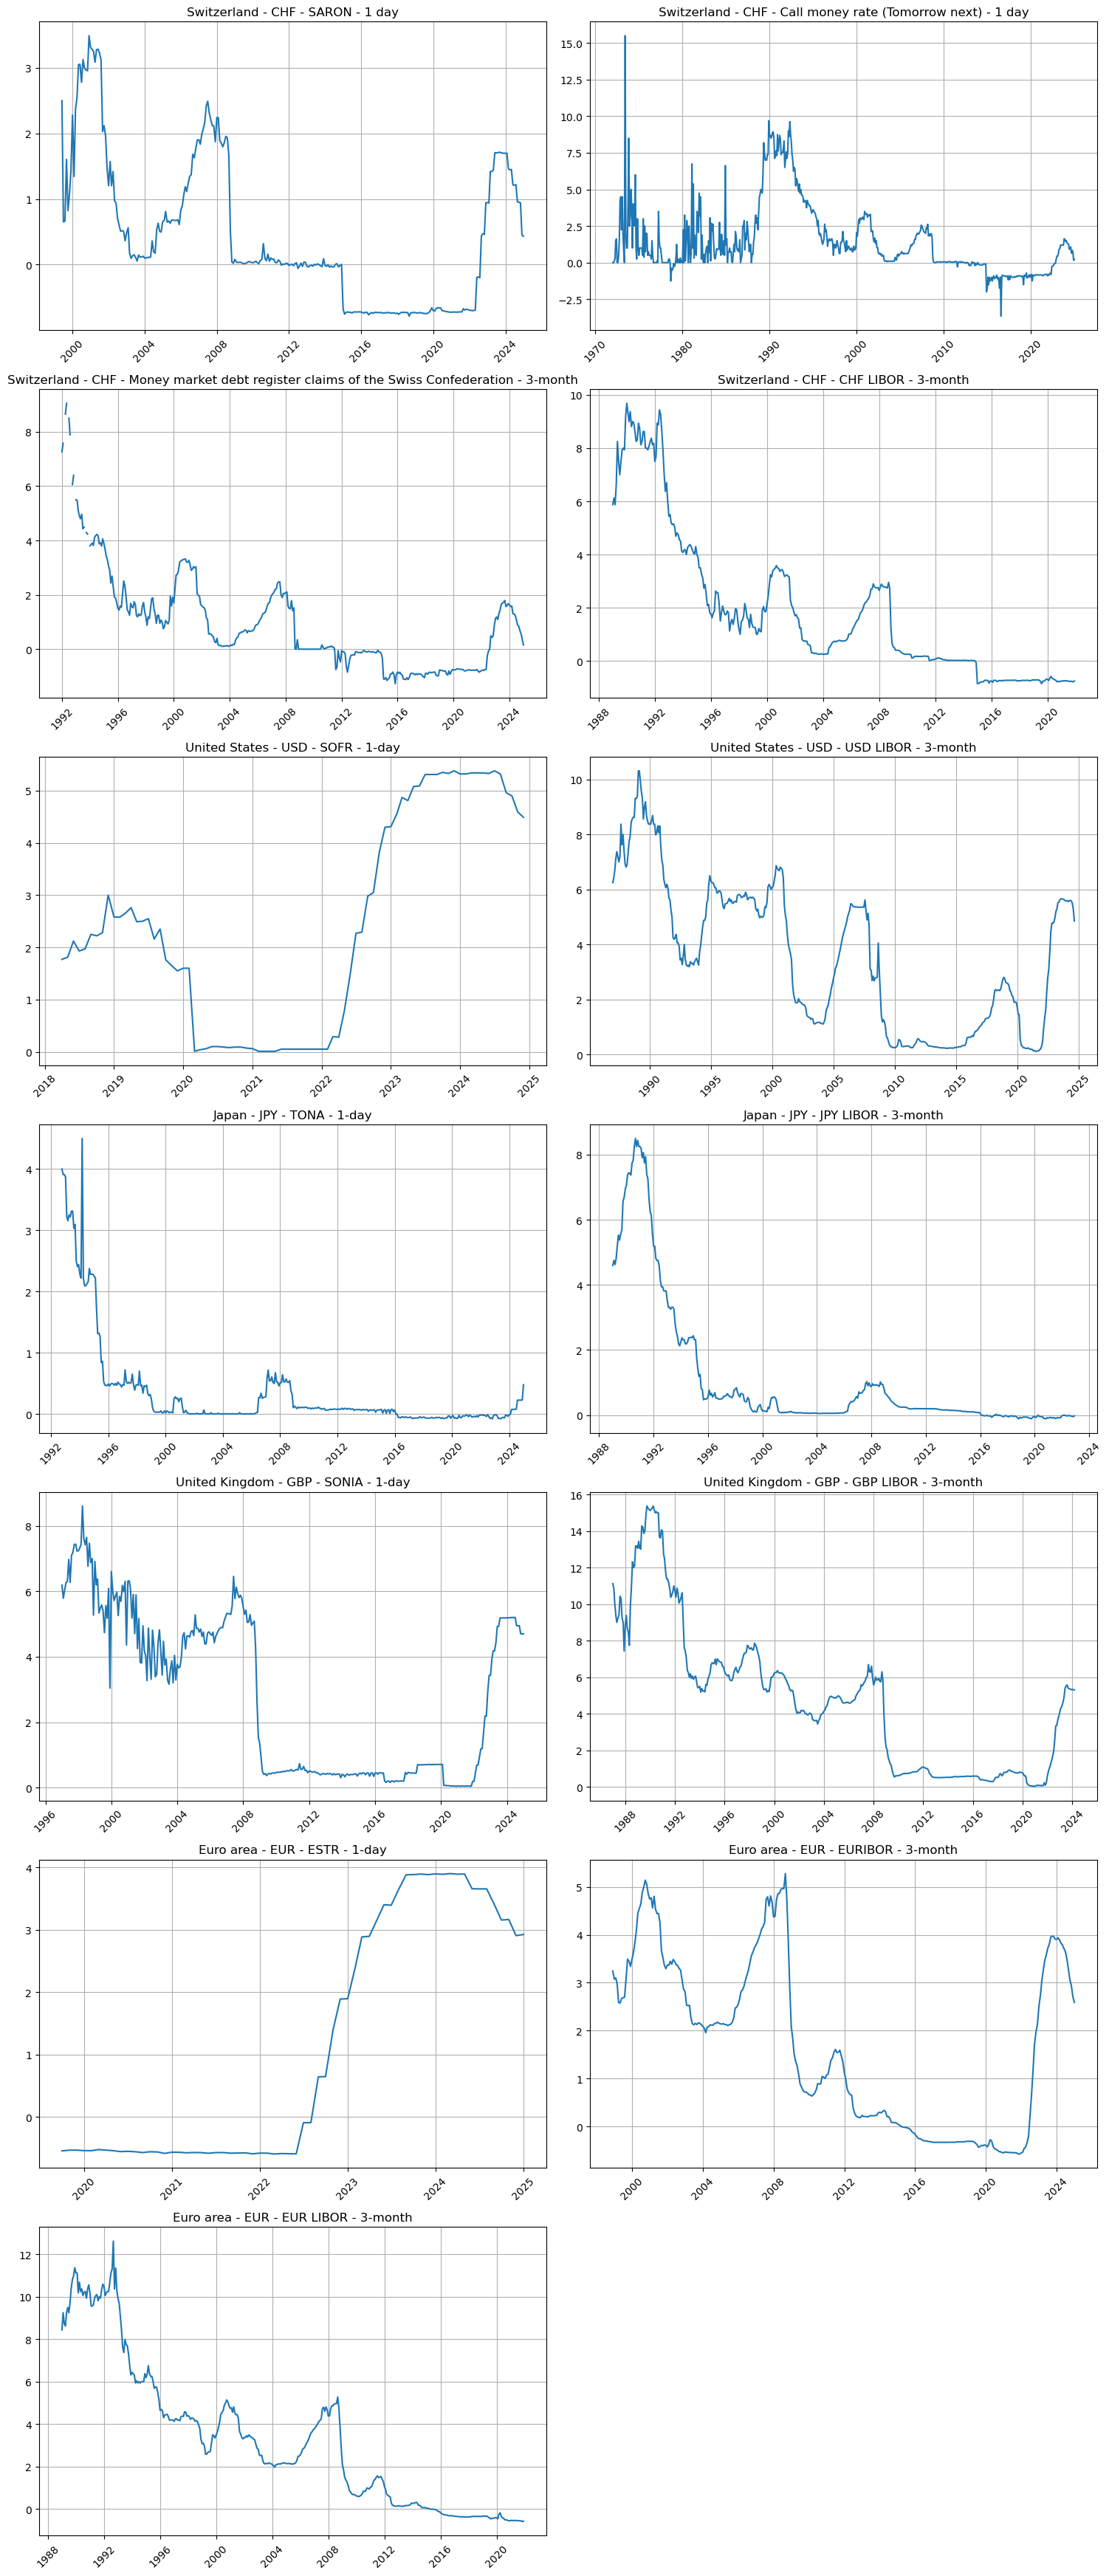

In [26]:
from visualization_function import plot_all_columns

plot_all_columns(interest_rates_df)

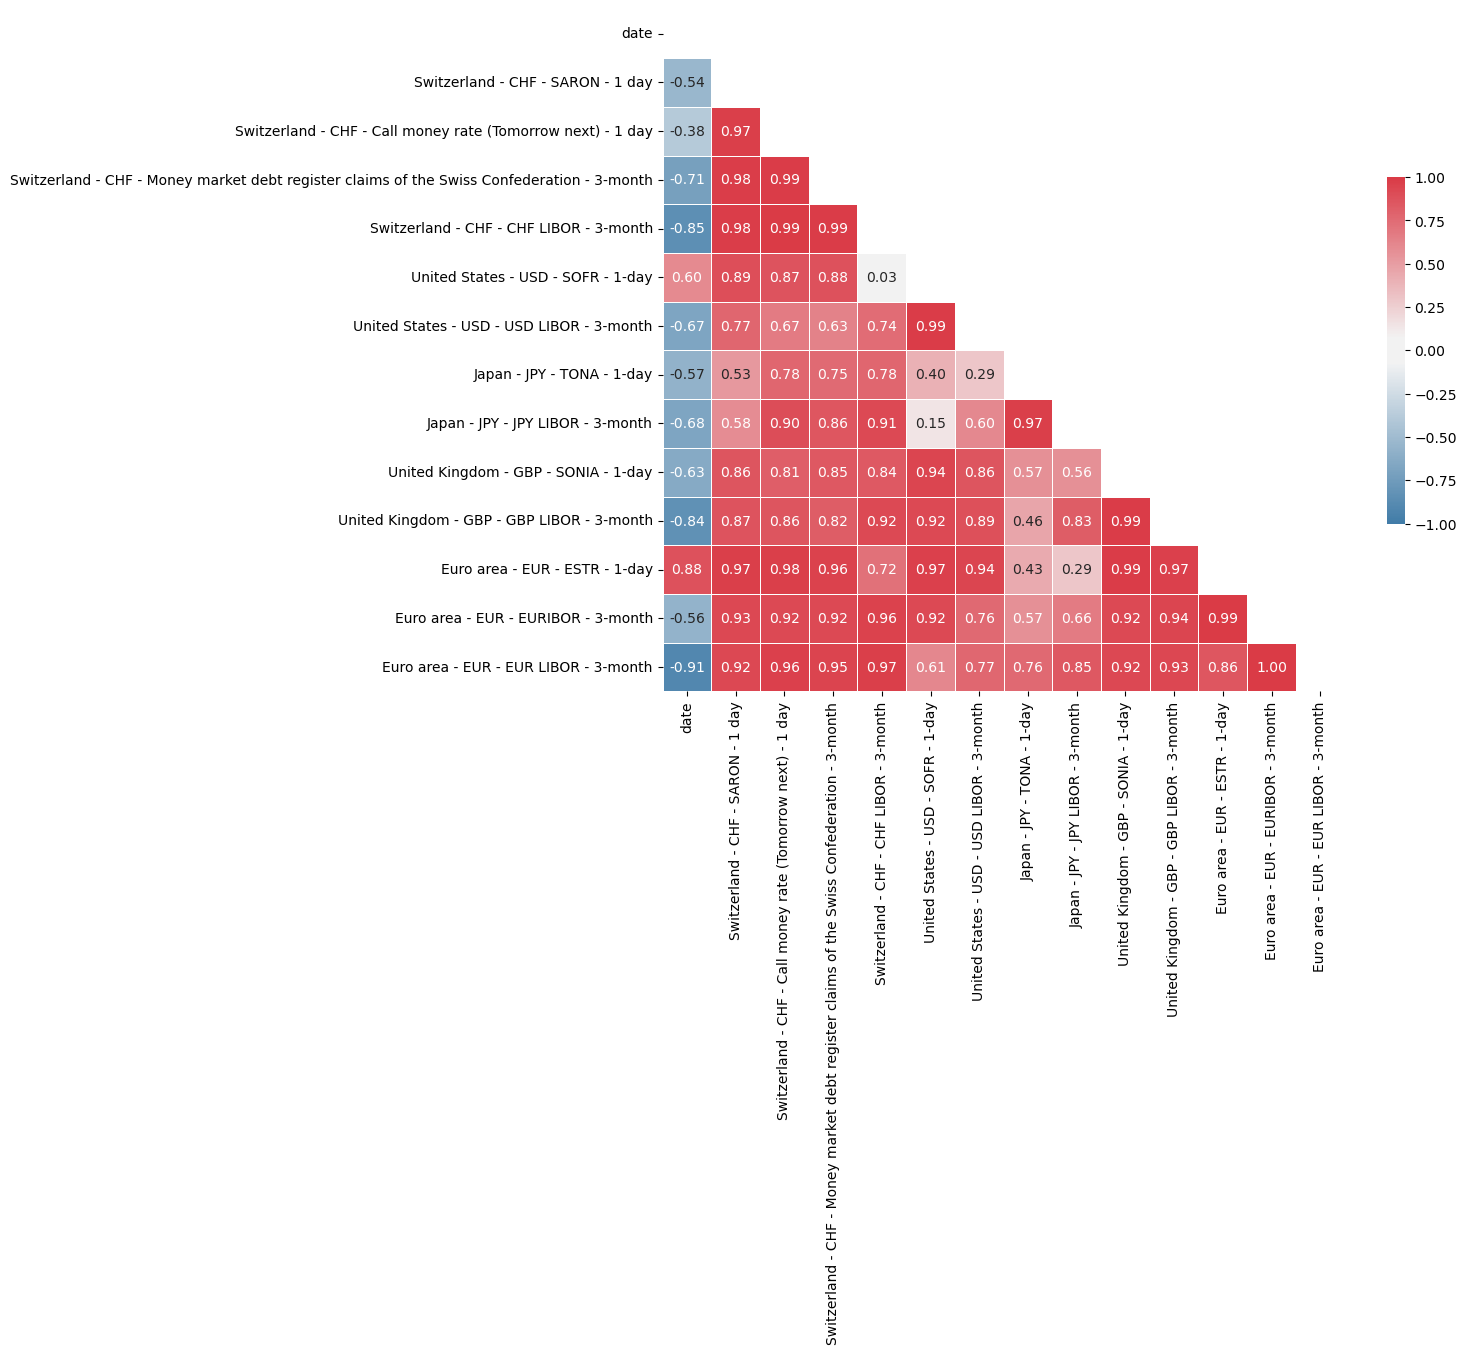

In [28]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(interest_rates_df)

In [36]:
from snb_data_processing import group_data_by_year

yearly_interest_rates_df=group_data_by_year(interest_rates_df)
yearly_interest_rates_df

,date,Switzerland - CHF - SARON - 1 day,Switzerland - CHF - Call money rate (Tomorrow next) - 1 day,Switzerland - CHF - Money market debt register claims of the Swiss Confederation - 3-month,Switzerland - CHF - CHF LIBOR - 3-month,United States - USD - SOFR - 1-day,United States - USD - USD LIBOR - 3-month,Japan - JPY - TONA - 1-day,Japan - JPY - JPY LIBOR - 3-month,United Kingdom - GBP - SONIA - 1-day,United Kingdom - GBP - GBP LIBOR - 3-month,Euro area - EUR - ESTR - 1-day,Euro area - EUR - EURIBOR - 3-month,Euro area - EUR - EUR LIBOR - 3-month
0,1972-01-01,NaN,1.18750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-01-01,NaN,3.67708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1974-01-01,NaN,2.91667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1975-01-01,NaN,1.30208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1976-01-01,NaN,0.41667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1977-01-01,NaN,0.63542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1978-01-01,NaN,-0.16667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1979-01-01,NaN,0.14583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1980-01-01,NaN,1.30208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1981-01-01,NaN,2.54688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Monetary base

In [1]:
from snb_data_processing import get_and_process_snb_data

monthly_monetary_base_df = get_and_process_snb_data(url="https://data.snb.ch/api/cube/snbmoba/data/json/en")
monthly_monetary_base_df

,date,Origination - Relevant foreign currency positions,Origination - Securities portfolio,Origination - Money market transactions,Origination - Other,Origination - Monetary base,Utilisation - Banknotes in circulation,Utilisation - Sight deposit accounts of domestic banks,Utilisation - Monetary base,Seasonally adjusted - Monetary base,Seasonally adjusted - Seasonal factor
0,1950-01-01,NaN,NaN,NaN,NaN,5824.0,4295.0,1529.0,5824.0,NaN,NaN
1,1950-02-01,NaN,NaN,NaN,NaN,5698.0,4161.0,1537.0,5698.0,NaN,NaN
2,1950-03-01,NaN,NaN,NaN,NaN,5747.0,4191.0,1556.0,5747.0,NaN,NaN
3,1950-04-01,NaN,NaN,NaN,NaN,5660.0,4189.0,1471.0,5660.0,NaN,NaN
4,1950-05-01,NaN,NaN,NaN,NaN,5647.0,4182.0,1465.0,5647.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
896,2024-09-01,803049.0,3876.0,0.0,277795.0,529130.0,72049.0,457081.0,529130.0,529858.0,0.998626
897,2024-10-01,830422.0,3938.0,0.0,308632.0,525728.0,71941.0,453787.0,525728.0,526703.0,0.998149
898,2024-11-01,834166.0,3942.0,0.0,313152.0,524956.0,72013.0,452943.0,524956.0,525976.0,0.998061
899,2024-12-01,844365.0,3958.0,0.0,331378.0,516945.0,73173.0,443772.0,516945.0,516801.0,1.000279


In [2]:
from snb_data_processing import group_data_by_year

yearly_monetary_base_df = group_data_by_year(monthly_monetary_base_df)
yearly_monetary_base_df

,date,Origination - Relevant foreign currency positions,Origination - Securities portfolio,Origination - Money market transactions,Origination - Other,Origination - Monetary base,Utilisation - Banknotes in circulation,Utilisation - Sight deposit accounts of domestic banks,Utilisation - Monetary base,Seasonally adjusted - Monetary base,Seasonally adjusted - Seasonal factor
0,1950-01-01,NaN,NaN,NaN,NaN,5753.16667,4239.58333,1513.58333,5753.16667,NaN,NaN
1,1951-01-01,NaN,NaN,NaN,NaN,5692.66667,4419.58333,1273.08333,5692.66667,NaN,NaN
2,1952-01-01,NaN,NaN,NaN,NaN,5775.91667,4595.08333,1180.83333,5775.91667,NaN,NaN
3,1953-01-01,NaN,NaN,NaN,NaN,6164.58333,4780.75000,1383.83333,6164.58333,NaN,NaN
4,1954-01-01,NaN,NaN,NaN,NaN,6261.58333,4902.33333,1359.25000,6261.58333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
71,2021-01-01,1.009690e+06,4001.75000,110.75000,288184.58333,725618.25000,88283.91667,637334.33333,725618.25000,725628.08333,0.99999
72,2022-01-01,9.719643e+05,3740.91667,8215.00000,277096.91667,706823.33333,87182.41667,619640.91667,706823.33333,706811.08333,0.99997
73,2023-01-01,8.063621e+05,3638.75000,144.91667,246689.33333,563456.41667,76504.58333,486951.83333,563456.41667,563453.66667,0.99998
74,2024-01-01,8.100418e+05,3876.08333,0.00000,284594.75000,529323.16667,73261.58333,456061.58333,529323.16667,529324.50000,0.99999


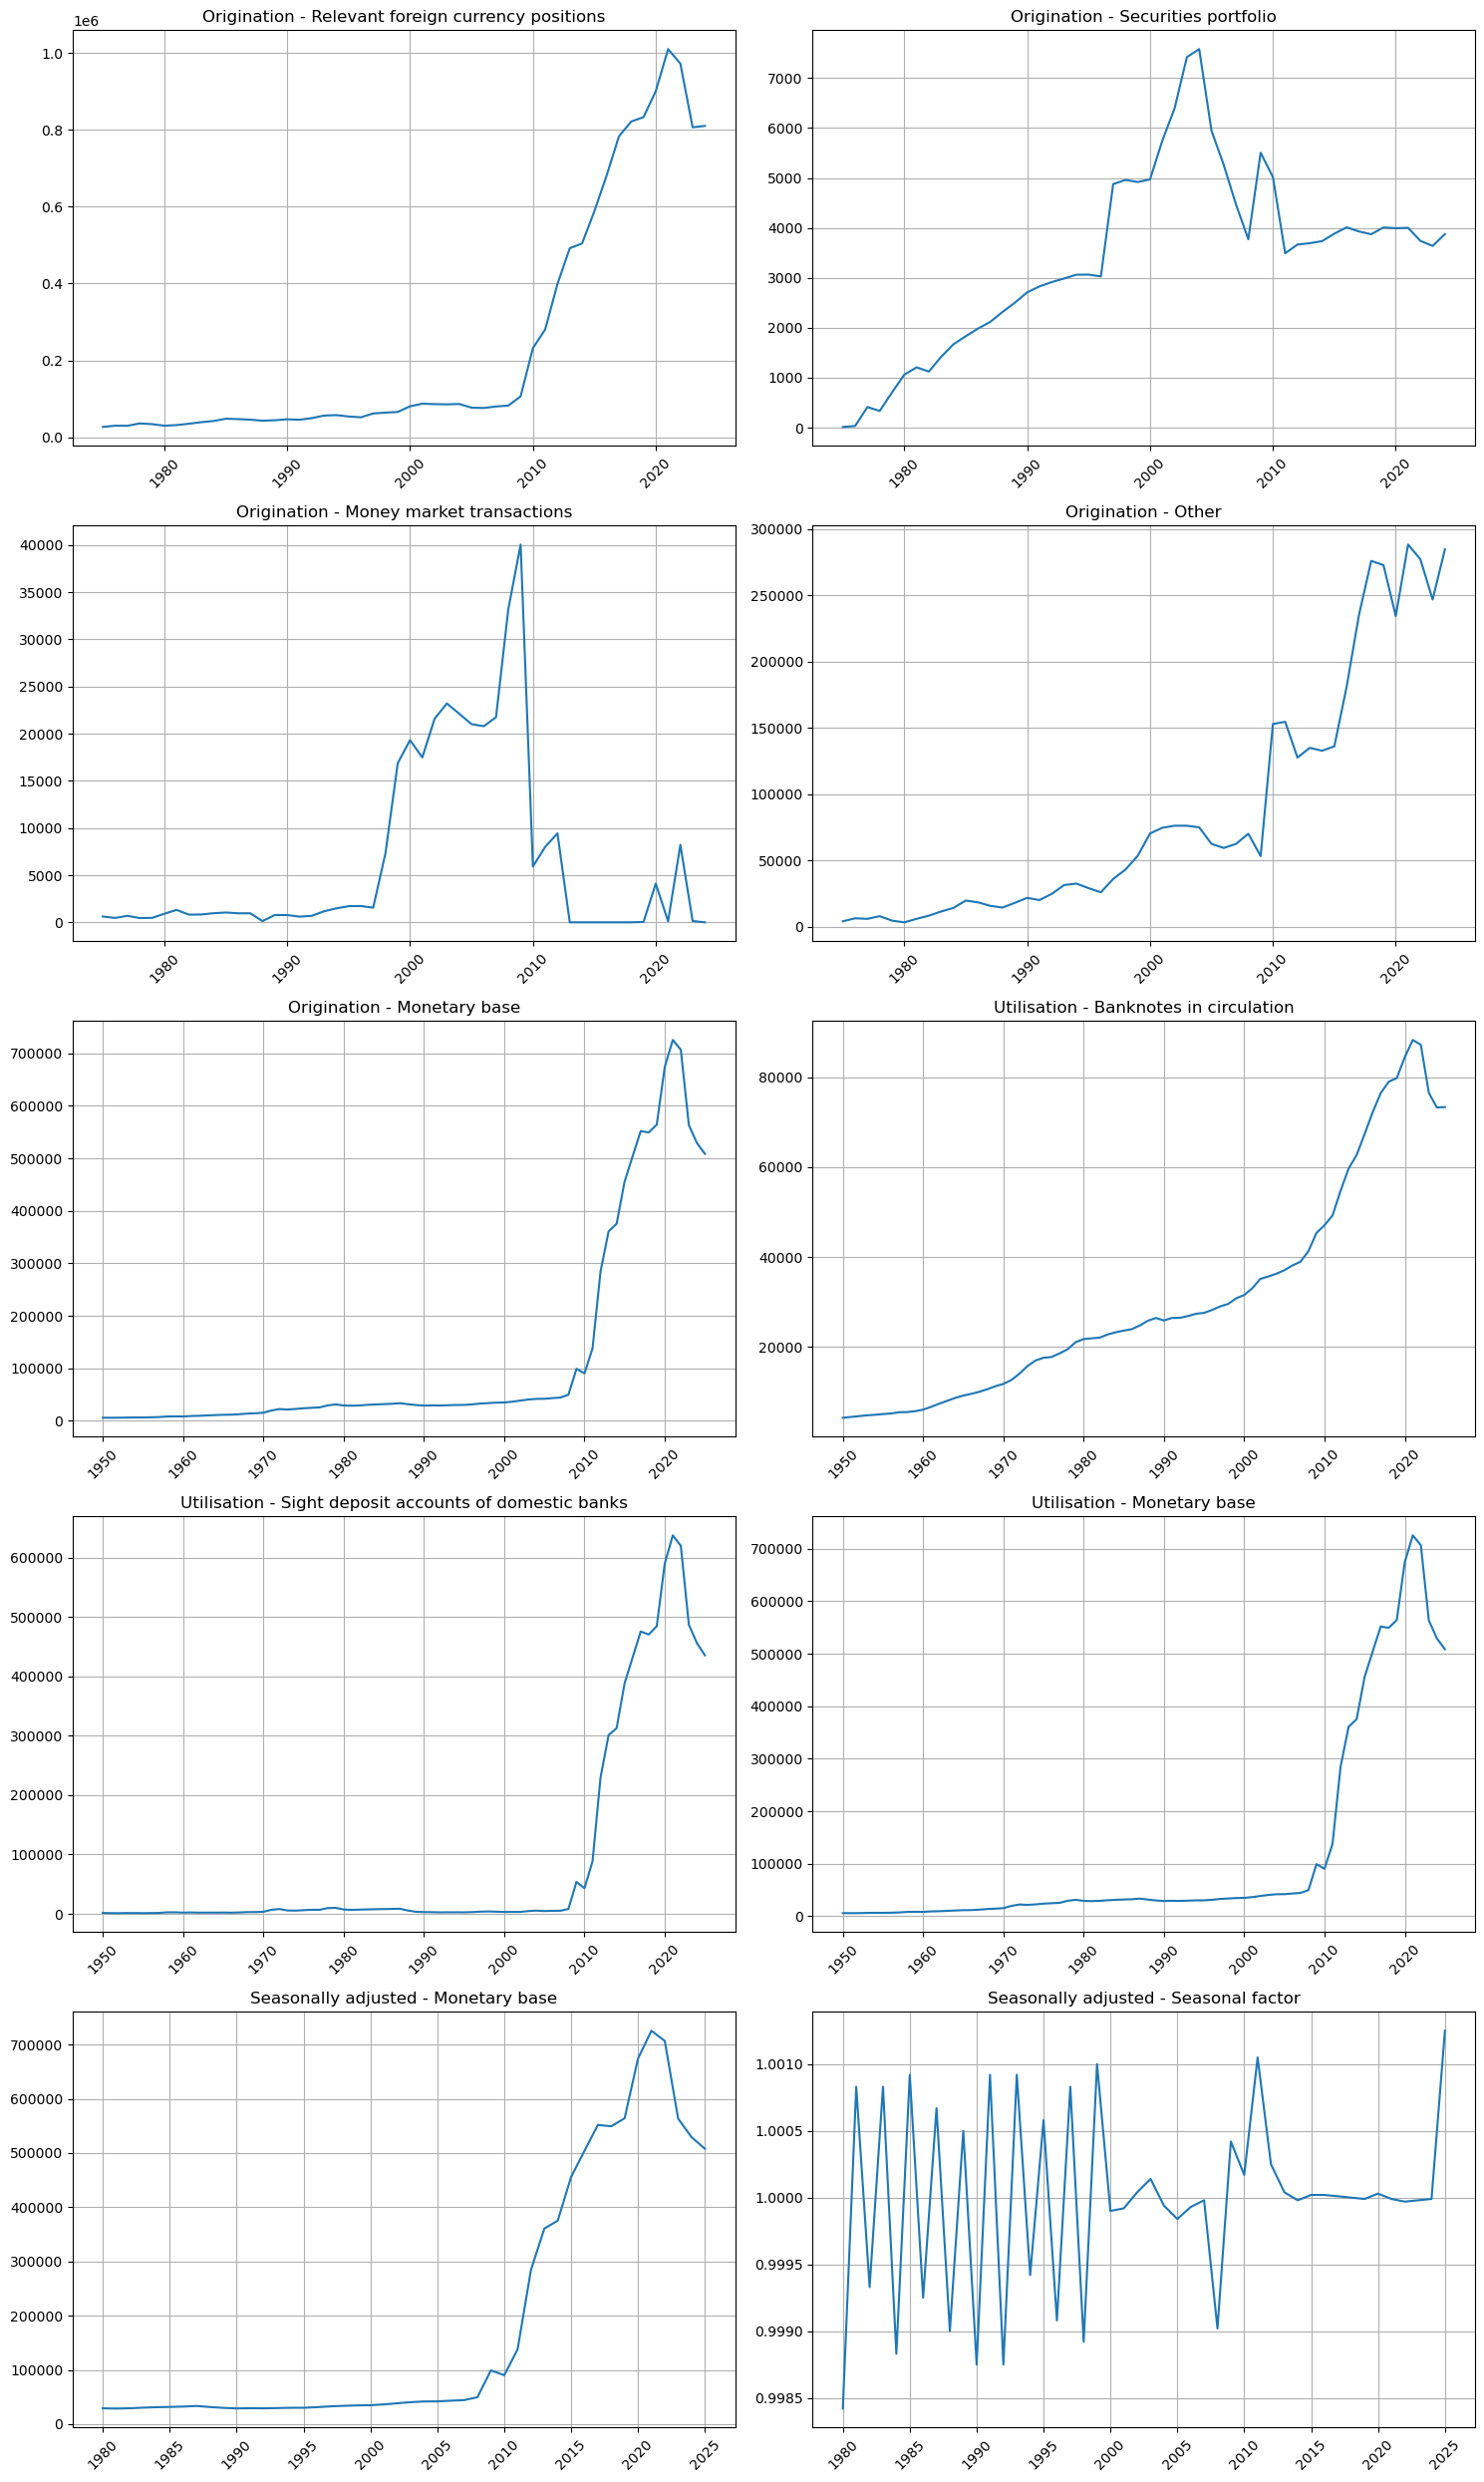

In [3]:
from visualization_function import plot_all_columns

plot_all_columns(yearly_monetary_base_df)

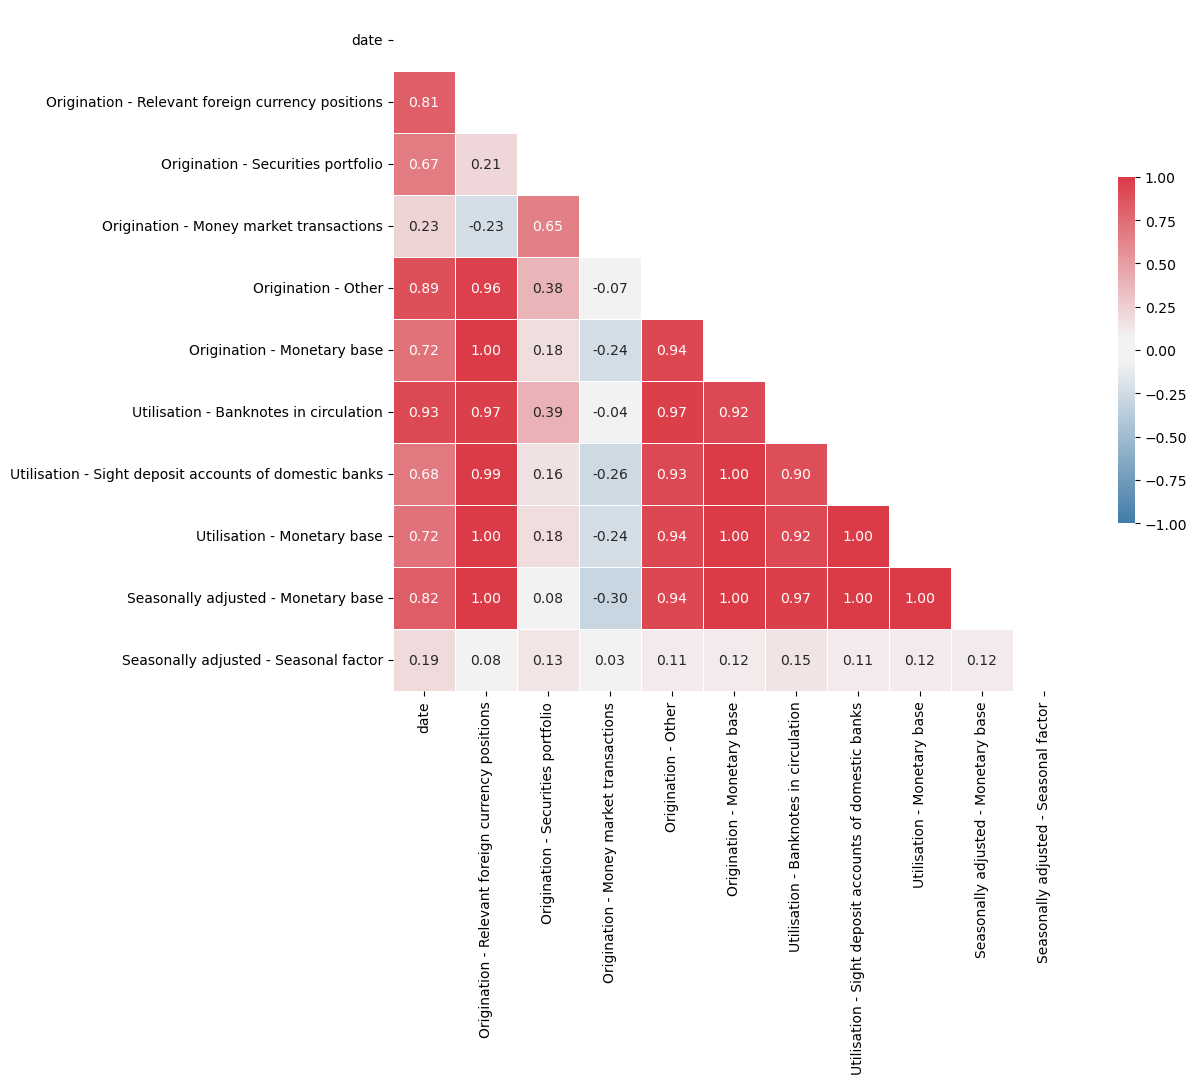

In [4]:
from visualization_function import plot_correlation_heatmap

plot_correlation_heatmap(yearly_monetary_base_df)

## Monetary aggregates M1, M2 and M3

In [ ]:
from snb_data_processing import get_and_process_snb_data, get_and_process_snb_data_two_header_levels

monthly_monetary_aggregate_df = get_and_process_snb_data_two_header_levels(url="https://data.snb.ch/api/cube/snbmonagg/data/json/en")
monthly_monetary_aggregate_df


column_name,date,Change from the corresponding month of the previous year - Currency in circulation,Change from the corresponding month of the previous year - Deposits in transaction accounts,Change from the corresponding month of the previous year - Monetary aggregate M1,Change from the corresponding month of the previous year - Monetary aggregate M2,Change from the corresponding month of the previous year - Monetary aggregate M3,Change from the corresponding month of the previous year - Savings deposits,Change from the corresponding month of the previous year - Sight deposits,Change from the corresponding month of the previous year - Time deposits,Level - Currency in circulation,Level - Deposits in transaction accounts,Level - Monetary aggregate M1,Level - Monetary aggregate M2,Level - Monetary aggregate M3,Level - Savings deposits,Level - Sight deposits,Level - Time deposits
0,1984-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23749.0,27320.0,95432.0,205928.0,252995.0,110496.0,44363.0,47067.0
1,1985-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22193.0,28005.0,91752.0,202569.0,252820.0,110817.0,41554.0,50251.0
2,1985-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235.0,28443.0,89327.0,200361.0,253420.0,111034.0,38649.0,53059.0
3,1985-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22318.0,28280.0,90191.0,201096.0,256442.0,110905.0,39593.0,55346.0
4,1985-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21968.0,28387.0,90315.0,200451.0,257249.0,110136.0,39960.0,56798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,2024-09-01,-3.005002,-6.413741,-4.022466,-0.582950,1.753559,6.521845,-4.079715,13.601141,71560.0,17218.0,609370.0,936783.0,1147888.0,327413.0,520592.0,211105.0
478,2024-10-01,-2.637668,-3.530587,-2.978578,0.432372,1.397569,7.456434,-3.006616,6.007520,71536.0,17378.0,611429.0,940279.0,1148076.0,328850.0,522515.0,207797.0
479,2024-11-01,-2.388011,-1.462715,-1.120332,1.960679,1.819295,8.277883,-0.935069,1.159417,71778.0,17852.0,621257.0,953054.0,1155649.0,331797.0,531627.0,202595.0
480,2024-12-01,-1.972041,-1.286298,2.367945,4.632341,1.869456,9.202759,3.112012,-10.508651,73768.0,17881.0,635967.0,972092.0,1157672.0,336125.0,544318.0,185580.0


In [2]:
from snb_data_processing import group_data_by_year

yearly_monetary_aggregate_df = group_data_by_year(monthly_monetary_aggregate_df)
yearly_monetary_aggregate_df

column_name,date,Change from the corresponding month of the previous year - Currency in circulation,Change from the corresponding month of the previous year - Deposits in transaction accounts,Change from the corresponding month of the previous year - Monetary aggregate M1,Change from the corresponding month of the previous year - Monetary aggregate M2,Change from the corresponding month of the previous year - Monetary aggregate M3,Change from the corresponding month of the previous year - Savings deposits,Change from the corresponding month of the previous year - Sight deposits,Change from the corresponding month of the previous year - Time deposits,Level - Currency in circulation,Level - Deposits in transaction accounts,Level - Monetary aggregate M1,Level - Monetary aggregate M2,Level - Monetary aggregate M3,Level - Savings deposits,Level - Sight deposits,Level - Time deposits
0,1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23749.00000,27320.00000,95432.00000,2.059280e+05,2.529950e+05,110496.00000,44363.00000,47067.00000
1,1985-01-01,-1.97482,11.89605,4.78456,3.76734,5.89221,2.88879,4.02362,15.18899,22120.58333,28907.66667,92117.66667,2.022922e+05,2.582632e+05,110174.50000,41089.41667,55971.08333
2,1986-01-01,1.22039,10.71462,6.78282,6.49869,6.56908,6.26934,7.04556,6.89783,22393.50000,32005.00000,98359.00000,2.154344e+05,2.752481e+05,117075.41667,43960.50000,59813.66667
3,1987-01-01,2.68659,14.16789,9.66570,8.46401,9.28115,7.44669,9.95239,12.31777,22991.16667,36555.08333,107906.25000,2.337036e+05,3.008548e+05,125797.33333,48360.00000,67151.16667
4,1988-01-01,4.99140,12.48543,13.74221,12.20849,9.64179,10.92412,18.94802,0.74763,24141.08333,41077.25000,122557.66667,2.620782e+05,3.296947e+05,139520.58333,57339.33333,67616.41667
5,1989-01-01,2.29459,-1.32587,-4.08149,-5.64877,5.91507,-7.01801,-8.66858,50.53977,24686.16667,40503.25000,117535.00000,2.471799e+05,3.491841e+05,129644.91667,52345.58333,102004.16667
6,1990-01-01,-1.93539,-6.67080,-5.07417,-7.91064,1.98608,-10.47346,-5.32174,27.33391,24211.33333,37795.50000,111570.33333,2.275203e+05,3.560828e+05,115950.00000,49563.50000,128562.41667
7,1991-01-01,2.67302,3.35864,1.96256,1.71040,2.66655,1.49037,0.60767,4.46378,24852.00000,39057.16667,113744.00000,2.313700e+05,3.655653e+05,117626.00000,49834.83333,134195.33333
8,1992-01-01,0.34154,5.99485,1.98574,2.79062,2.09714,3.57748,-0.31474,0.86831,24938.75000,41385.25000,116011.25000,2.378605e+05,3.732302e+05,121849.25000,49687.25000,135369.66667
9,1993-01-01,1.65185,12.62937,10.53134,16.12641,3.93410,21.45741,13.27485,-17.40613,25348.00000,46615.58333,128211.75000,2.761994e+05,3.879232e+05,147987.66667,56248.16667,111723.83333
